In [1]:
# Importando bibliotecas
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

# Importando bibliotecas úteis para a rede
from torch.utils.data import DataLoader
from torchvision.ops import box_iou
import torchvision.transforms as transforms
import torchvision.utils as torch_utils
import torch.nn as nn

# Importando TravNet e seu dataset
import sys

sys.path.append('../src')

from models.TravNet_ViT import TravNet
from models.TravNet_ViT import VisualTransformer # ADICIONAR ViT
from models.TravNet_ViT import CustomTransformer # ADICIONAR ViT
from utils.TravDataloader import TravNetDataset

## Initialization

In [2]:
class Object(object):
    pass

params = Object() # Cria um objeto para armazenar os parâmetros
# Parametros do dataset
params.data_path        = r'../../data/' 
params.csv_path         = os.path.join(params.data_path, 'data.csv')
params.preproc          = True  # Vertical flip augmentation - inverte a imagem verticalmente
params.depth_mean       = 3.5235
params.depth_std        = 10.6645

# Parametros de treino
params.seed             = 230 # Seed para o gerador de números aleatórios - como saber a melhor seed para o modelo?
params.epochs           = 25 # MUDAR AQUI AS ÉPOCAS
params.batch_size       = 16
params.learning_rate    = 1e-4
params.weight_decay     = 1e-5

# Parametros do modelo 
params.pretrained = True
params.load_network_path = None 
params.input_size       = (424, 240)
params.output_size      = (424, 240)
params.output_channels  = 1
params.bottleneck_dim   = 256

# Parametros da ViT
transformer_params = Object()
transformer_params.in_channels = 3
transformer_params.hidden_dim = 256
transformer_params.num_heads = 8
transformer_params.num_layers = 12

In [3]:
torch.manual_seed(params.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(params.seed) 

# Selecionar GPU ou CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [4]:
def load_data():
    # Transformações para o dataset
    # Pré-estudo ablativo - Alterar aqui
    transform = transforms.Compose([
                transforms.ToPILImage(), # Converte o tensor para uma imagem PIL
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.RandomChoice([
                    transforms.RandomHorizontalFlip(p=1),
                    transforms.RandomRotation(15),
                    transforms.RandomInvert(0.5),
                ]),
                transforms.ToTensor(), # Converte a imagem PIL para um tensor
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normaliza o tensor (média e desvio padrão)
                ])
    
    '''
    transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
    '''

    dataset = TravNetDataset(params, transform)

    # Divide o dataset em treino e validação 
    train_size, val_size = int(0.8*len(dataset)), np.ceil(0.2*len(dataset)).astype('int')
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size]) # Separa os dados de acordo com os tamanhos estabelecidos e embaralha

    train_loader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=params.batch_size, shuffle=True, num_workers=2)

    print('Total loaded %d images' % len(dataset))
    print('Loaded %d train images' % train_size)
    print('Loaded %d valid images' % val_size)

    return train_loader, val_loader

In [5]:
def get_bounding_box(binary_image):
    binary_image_np = binary_image.detach().cpu().numpy()
    binary_image_np = np.where(binary_image_np > 0.5, 255, 0).astype(np.uint8)

    contours, _ = cv2.findContours(binary_image_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bounding_boxes = []

    for contour in contours:
        x, y, largura, altura = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, largura, altura))

    return bounding_boxes

In [6]:
def get_iou(ground_truth, predicted):
    iou_list = []

    for gt_box, pred_box in zip(ground_truth, predicted):
        x1_1, y1_1, largura_1, altura_1 = gt_box
        x1_2, y1_2, largura_2, altura_2 = pred_box

        x2_1 = x1_1 + largura_1
        y2_1 = y1_1 + altura_1
        x2_2 = x1_2 + largura_2
        y2_2 = y1_2 + altura_2

        x_overlap = max(0, min(x2_1, x2_2) - max(x1_1, x1_2))
        y_overlap = max(0, min(y2_1, y2_2) - max(y1_1, y1_2))
        intersection = x_overlap * y_overlap

        gt_area = largura_1 * altura_1
        pred_area = largura_2 * altura_2

        iou = intersection / (gt_area + pred_area - intersection)
        iou_list.append(iou)

    return iou_list

In [7]:
# # Pré-estudo ablativo - Alterar aqui
def fit(net, criterion, optimizer, scheduler, train_loader, val_loader):    

    # Pré-estudo ablativo - Alterar aqui
    patience = 10 # Número de épocas sem melhora na perda de validação para parar o treinamento
    counter = 0 

    best_val_loss = np.inf 
    train_loss_list = [] 
    val_loss_list = [] 

    for epoch in range(params.epochs):
        net.train()
        train_loss = 0.0 
        
        for i, data in enumerate(train_loader):
            data = (item.to(device).type(torch.float32) for item in data) 
            color_img, depth_img, path_img, mu_img, nu_img, weight = data 

            # Forward pass
            pred = net(color_img, depth_img) # EDITAR AQUI CASO QUEIRA TESTAR COM/SEM PROFUNDIDADE
            label = mu_img

            loss = weight*criterion(pred*path_img, label) 
            loss = torch.mean(loss)
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 

            train_loss += loss.item() 

        train_loss /= len(train_loader) 
        train_loss_list.append(train_loss) 

        if (epoch) % 10 == 0:
            outstring = 'Epoch [%d/%d], Loss: ' % (epoch+1, params.epochs)
            print(outstring, train_loss)
            print('Learning Rate for this epoch: {}'.format(optimizer.param_groups[0]['lr']))

        # Testando o modelo 
        with torch.no_grad():
            net.eval() 

            val_loss = 0.0 

            for i, data in enumerate(val_loader):
                data = (item.to(device).type(torch.float32) for item in data)
                color_img, depth_img, path_img, mu_img, nu_img, weight = data

                pred = net(color_img, depth_img) # EDITAR AQUI CASO QUEIRA TESTAR COM/SEM PROFUNDIDADE
                label = mu_img

                loss = weight*criterion(pred*path_img, label)
                loss = torch.mean(loss)

                val_loss += loss.item()

            val_loss /= len(val_loader)
            val_loss_list.append(val_loss)
        
            # Pré-estudo ablativo - Alterar aqui   
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0

                # Salva o modelo
                print('Updating best validation loss: %.5f' % best_val_loss)
                torch.save(net.state_dict(), 'checkpoints/best_predictor_depth.pth')

            else:
                counter += 1
                print('No improvement since last epoch: %d' % counter)
                if counter >= patience:
                    net.module.load_state_dict(torch.load('checkpoints/best_predictor_depth.pth'))
                    print('Early stopping!')
                    break

        # Pré-estudo ablativo - Alterar aqui    
        scheduler.step() 

        if (epoch + 1) % 5 == 0:
            plt.figure(figsize = (14,14))
            plt.subplot(1, 3, 1)
            plt.imshow(color_img[0].permute(1, 2, 0).cpu().numpy())
            plt.subplot(1, 3, 2)
            plt.imshow(255*pred[0,0,:,:].detach().cpu().numpy(), vmin=0, vmax=255)
            plt.show(block=False)
            
            label = get_bounding_box(path_img[0, 0, :, :])
            pred = get_bounding_box(pred[0, 0, :, :])
        
            get_iou(label, pred)

    print('Training Loss list: ', train_loss_list)
    print('Validation Loss list: ', val_loss_list)

    plt.plot(train_loss_list, label='Treinamento')
    plt.plot(val_loss_list, label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()

In [8]:
# REINICIALIZAR AQUI
net = TravNet(params, transformer_params) # Instancia a rede - # EDITAR AQUI CASO QUEIRA TESTAR COM/SEM PROFUNDIDADE

# Usado para carregar um modelo salvo
if params.load_network_path is not None:
    print('Loading saved network from {}'.format(params.load_network_path))
    net.load_state_dict(torch.load(params.load_network_path))

print("Let's use", torch.cuda.device_count(), "GPUs!") 
net = torch.nn.DataParallel(net).to(device) 

Let's use 1 GPUs!


In [9]:
# Inicializa um tensor de teste
# EDITAR AQUI CASO QUEIRA TESTAR COM/SEM PROFUNDIDADE
test = net(torch.rand([2, 3, params.input_size[1], params.input_size[0]]).to(device), torch.rand([2, 1, params.input_size[1], params.input_size[0]]).to(device))
print('test.shape:', test.shape)

RuntimeError: CUDA out of memory. Tried to allocate 38.58 GiB (GPU 0; 3.95 GiB total capacity; 414.17 MiB already allocated; 2.15 GiB free; 522.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
train_data, val_data = load_data() 

Initializing dataset
Max score: 24.567
Min score: 0.0
Depth mean: 3.438056670303481
Depth std: 10.458746256918245
Total loaded 16558 images
Loaded 13246 train images
Loaded 3312 valid images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


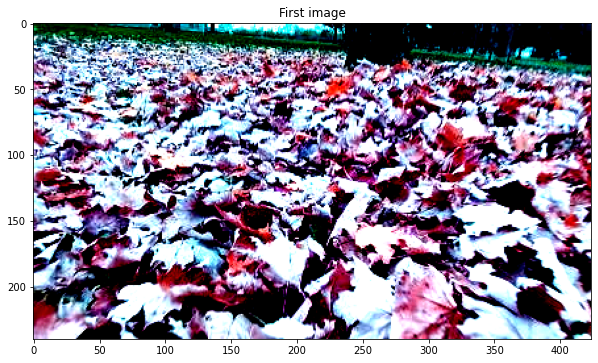

In [ ]:
data_iterator = iter(train_data)
data = next(data_iterator)
first_image = data[0][0]
first_image = torch_utils.make_grid(first_image)

plt.figure(figsize=(10, 10))
plt.imshow(first_image.permute(1, 2, 0))
plt.title('First image')
plt.show() 

In [ ]:
for i, data in enumerate(train_data):
    data = (item.to(device).type(torch.float32) for item in data)
    color_img, depth_img, path_img, mu_img, nu_img, weight = data

    color_img_array = np.transpose(color_img[0].cpu().numpy(), (1, 2, 0))
    color_img_array = (color_img_array * 255).astype(np.uint8)

    bounding_box_path = get_bounding_box(path_img[0, 0, :, :])
    bounding_box_mu = get_bounding_box(mu_img[0, 0, :, :])

    for x, y, largura, altura in bounding_box_path:
        cv2.rectangle(color_img_array, (x, y), (x + largura, y + altura), (0, 255, 0), 2)

    for x, y, largura, altura in bounding_box_mu:
        cv2.rectangle(color_img_array, (x, y), (x + largura, y + altura), (0, 0, 255), 2)

    cv2.imshow('Imagem com Bounding Boxes', color_img_array)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    iou_val = get_iou(bounding_box_path, bounding_box_mu)

    print(iou_val)

NameError: name 'train_data' is not defined

## Set up training tools and fitting

In [ ]:
criterion = torch.nn.L1Loss(reduction='none') # Perda L1 (erro absoluto médio)
optimizer = torch.optim.Adam(net.parameters(), lr=params.learning_rate, weight_decay=params.weight_decay) # Verificar o melhor otimizador para o modelo
# Pré-estudo ablativo - Alterar aqui   
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)

Epoch [1/25], Loss:  0.00909855232404203
Learning Rate for this epoch: 0.0001
Updating best validation loss: 0.00863
Updating best validation loss: 0.00836
Updating best validation loss: 0.00791
Updating best validation loss: 0.00754
Updating best validation loss: 0.00729


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


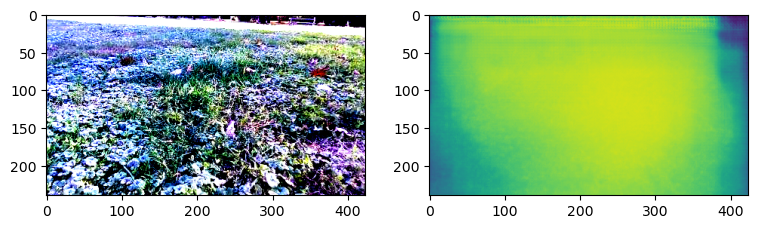

Updating best validation loss: 0.00685
Updating best validation loss: 0.00662
No improvement since last epoch: 1
No improvement since last epoch: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No improvement since last epoch: 3


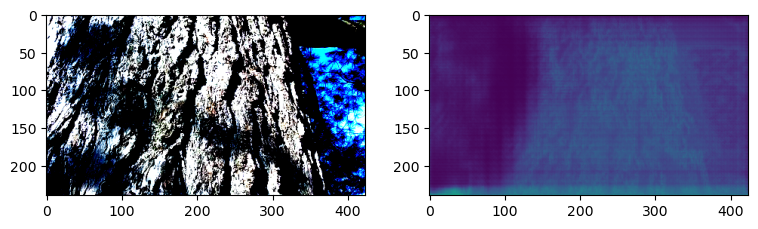

Epoch [11/25], Loss:  0.006324175942226893
Learning Rate for this epoch: 1e-05
Updating best validation loss: 0.00614
No improvement since last epoch: 1
Updating best validation loss: 0.00606
Updating best validation loss: 0.00601
Updating best validation loss: 0.00592


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


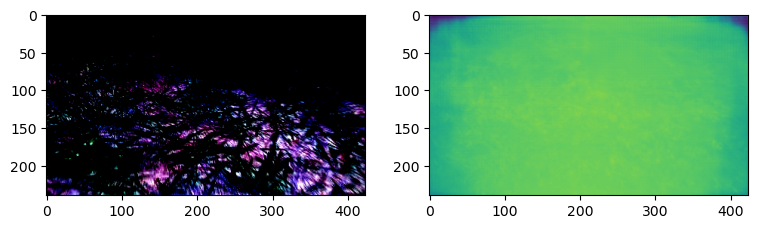

No improvement since last epoch: 1
Updating best validation loss: 0.00587
Updating best validation loss: 0.00585
Updating best validation loss: 0.00579
Updating best validation loss: 0.00578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


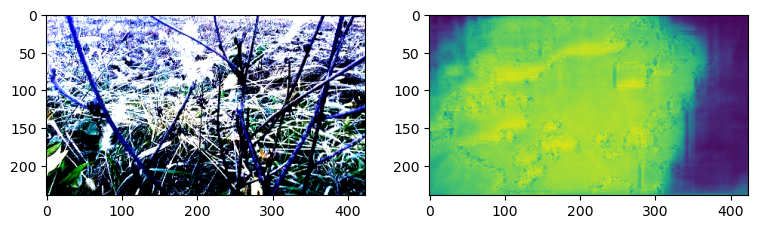

Epoch [21/25], Loss:  0.0057998894128086865
Learning Rate for this epoch: 1.0000000000000002e-06
No improvement since last epoch: 1
No improvement since last epoch: 2
No improvement since last epoch: 3
Updating best validation loss: 0.00574
Updating best validation loss: 0.00568


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


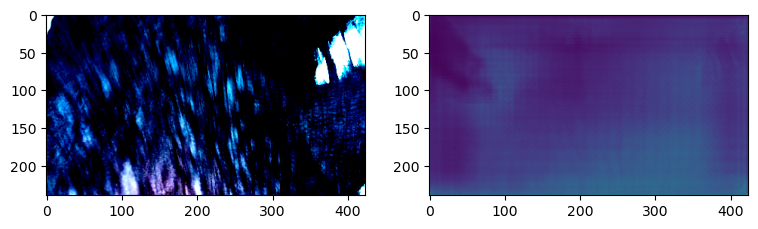

Training Loss list:  [0.00909855232404203, 0.008270590020015223, 0.007888528264177162, 0.007581962726797666, 0.007407865332381053, 0.007182285240946949, 0.007077941292523438, 0.006913631980966525, 0.006789096583025125, 0.006670242204844888, 0.006324175942226893, 0.00614980300427257, 0.006125210581914238, 0.00611265171977246, 0.006060214594269738, 0.006006777808711311, 0.005999730749208714, 0.005969873171441419, 0.005920542121874978, 0.005879363654589659, 0.0057998894128086865, 0.005763517517218555, 0.005745302194379077, 0.005732256358861698, 0.005726449051112665]
Validation Loss list:  [0.008632009583502864, 0.008361804079723315, 0.007906274796926962, 0.007538687129581464, 0.007290947132919362, 0.006849071431617086, 0.0066178871165727075, 0.006676634301202021, 0.007450079493638542, 0.006713629769980188, 0.006137644241064571, 0.006261621515271097, 0.006057012058538047, 0.006009704130814199, 0.005922249375487079, 0.0060276043728434885, 0.005871543663009497, 0.005845065616692106, 0.005791

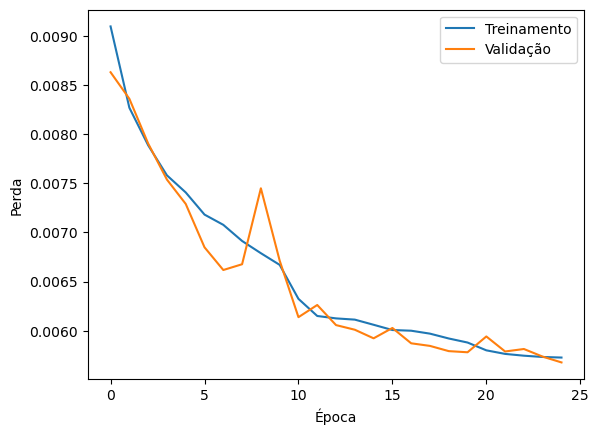

In [ ]:
# train = fit(net=net, criterion=criterion, optimizer=optimizer, train_loader=train_data, val_loader=val_data)
# Pré-estudo ablativo - Alterar aqui 
train = fit(net=net, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_data, val_loader=val_data) 